# Movie review classification by universal sentence encoder with 200 samples

## 1.Import library

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time
import seaborn as sns
import keras
import keras.layers as layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop,Adam
from keras import backend as K
np.random.seed(10)

keras.__version__
tf.__version__

Using TensorFlow backend.


'1.13.0-rc2'

## 2. Download the IMDB data as raw text

In [0]:
from tensorflow import keras

# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df


In [0]:
train, test = download_and_load_datasets()

2000 samples are taken

In [4]:
n=2000 
x = train.sample(n)
x.head()

,sentence,sentiment,polarity
16177,I saw this at an arty cinema that was also sho...,1,0
10457,Im proud to say I've seen all three Fast and F...,2,0
16677,Fassbinder's most lavish production sacrifices...,8,1
21963,A lot of promise and nothing more. An all-star...,2,0
7079,This is just one more of those hideous films t...,3,0


*Column* of "sentence" is used as features and "polarity" is used as label 

In [5]:
X=x.values[:,0:1]
print(np.shape(X))
X=X.reshape(n,)
print(np.shape(X))
X=X.tolist()
print(type(X))
print(len(X))

print(X[0:3])

(2000, 1)
(2000,)
<class 'list'>
2000
['I saw this at an arty cinema that was also showing "Last Days" and some Charlie Chaplin films. Based on the quality of the other features, I decided to give "Immortel" a chance. I nearly walked out of this movie, and I LIKE science-fiction! The story is set in a futuristic New York city, filled with Blade Runner-style sky advertisements and some similar debates about cloning/synthetic humans. Unfortunately, the screenplay was not condensed enough for an hour-and-forty-five-minute movie. Three groups exist in this world: humans, artificial humans, and Egyptian gods. The artificial humans seem to have the upper hand and control the politics of the city. The humans are slaves and are used for eugenics and organ donation. The Egyptian gods have a floating pyramid (modeled on the Great Pyramid of Khufu, and complete with a deteriorated exterior, leaving a smooth "cap" on the pyramid. Wouldn\'t a floating futuristic pyramid be in perfect condition?). T

In [6]:
Y=x.values[:,2:3]
print(np.shape(Y))
Y=Y.reshape(n,)
print(np.shape(Y))
Y=Y.tolist()
print(type(Y))
print(Y[0:3])

(2000, 1)
(2000,)
<class 'list'>
[0, 0, 1]


## 3. Universal Sentence Encoder is used to extract features from texts

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [8]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for X
messages = X

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
   

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
print(type(message_embeddings))
print(np.shape(message_embeddings))

<class 'numpy.ndarray'>
(2000, 512)


## 4. Develop model for classification


In [10]:
X=message_embeddings

model = Sequential()
model.add(Dense(16, input_dim=512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________________


## 5. Train the model with 200 samples


In [11]:
t=time.time()

model.compile(optimizer=Adam(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X, Y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.9)
#model.save_weights('pre_trained_glove_model.h5')

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Train on 199 samples, validate on 1801 samples
Epoch 1/50
199/199 [==============================] - 2s 10ms/step - loss: 0.6876 - acc: 0.5176 - val_loss: 0.6786 - val_acc: 0.6596
Epoch 2/50
199/199 [==============================] - 0s 535us/step - loss: 0.6697 - acc: 0.7337 - val_loss: 0.6679 - val_acc: 0.7368
Epoch 3/50
199/199 [==============================] - 0s 597us/step - loss: 0.6523 - acc: 0.7839 - val_loss: 0.6549 - val_acc: 0.7351
Epoch 4/50
199/199 [==============================] - 0s 542us/step - loss: 0.6360 - acc: 0.8241 - val_loss: 0.6405 - val_acc: 0.7662
Epoch 5/50
199/199 [==============================] - 0s 539us/step - loss: 0.6181 - acc: 0.8291 - val_loss: 0.6284 - val_acc: 0.7568
Epoch 6/50
199/199 [==============================] - 0s 525us/step - loss: 0.6006 - acc: 0.8492 - val_loss: 0.6167 - val_acc: 0.7590
Epoch 7/50
199/199 [==============================] - 0s 515us/step - loss: 0.5835 - acc: 0.8442 - val_loss: 0.6035 - val_acc: 0.7579
Epoch 8/50
199/1

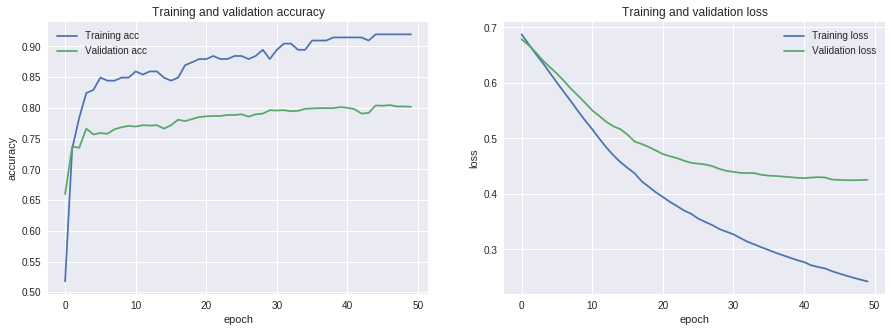

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()